# Visualization of the Trade History between China and U.S. States


In [1]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


https://www.uschina.org/reports/us-exports/national

In [107]:
# Load the Data

In [ ]:
import os
os.chdir('/content/gdrive/My Drive/data_vs_2019')

In [2]:
# read all data sets

export_china = pd.read_csv('DATA_Exports_to_China.csv') # export to china
import_china = pd.read_csv('DATA_Imports_from_China.csv') # import from china
export_world = pd.read_csv('DATA_Exports_to_World.csv') # export to world

ppi = pd.read_csv('PPIACO.csv') # producer price index
gdp_2018 = pd.read_excel('qgdpstate_0519.xlsx', sheet_name='Table 3', skiprows=4, usecols=[0, 5, 6, 7, 8]) # state gdp
trade_data = pd.read_excel('US_trade_data.xlsx') # US china trade from 1985
election = pd.read_excel('2016_election_result.xlsx') # 2016 presidential election

In [108]:
# Data Cleaning and Preparation

In [3]:
# transfer to year
ppi['year'] = ppi.DATE.str[:4].astype(int)

In [4]:
ppi_year = ppi.groupby('year').PPIACO.mean()
# ppi_year

In [5]:
# calculate ppi based on 2018 ppi = 1

ppi_year_2018 = ppi_year/ppi_year.loc[2018,]
ppi_year_2018 = ppi_year_2018.to_frame()
ppi_year_2018.reset_index(inplace=True)
ppi_year_2018.rename(columns={'year':'Year'}, inplace=True)
# ppi_year_2018

In [6]:
#prepare the gdp data

gdp_2018.columns = ['State', 'Q1', 'Q2', 'Q3', 'Q4']
gdp_2018 = gdp_2018.iloc[:-4, ]
gdp_2018 = gdp_2018.iloc[1:, ]
gdp_2018['region'] = 'Far West'
gdp_2018.loc[:8, 'region'] = 'New England'
gdp_2018.loc[8:15, 'region'] = 'Mideast'
gdp_2018.loc[15:21,'region'] = 'Great Lakes'
gdp_2018.loc[21:29, 'region'] = 'Plains'
gdp_2018.loc[29:42, 'region'] = 'Southeast'
gdp_2018.loc[42:47, 'region'] = 'Southwest'
gdp_2018.loc[47:53, 'region'] = 'Rocky Mountain'
gdp_2018 = gdp_2018[~gdp_2018.State.isin(['New England ', 'Mideast ', 'Great Lakes ', 'Plains ', 'Southeast ', 'Southwest ', 'Rocky Mountain ', 'Far West'])]
gdp_2018.reset_index(inplace=True, drop=True)
gdp_2018['gdp'] = gdp_2018.eval('Q1 + Q2 + Q3 + Q4')/4
gdp_2018.State = gdp_2018.State.str.strip() # remove the white space
# gdp_2018


In [8]:
trade_data_china = trade_data.loc[trade_data.CTYNAME == 'China', ['year', 'IYR', 'EYR']]
trade_data_china.reset_index(inplace=True, drop=True)
trade_data_china.columns = ['year', 'Imports', 'Exports']

# Part I: Visualizations of Trade between China and Individual US States

## Data pre-processing

In [9]:
# data tidying
export_china_melt = export_china.melt(id_vars = 'State', var_name = 'Year' , value_name = 'export') 
import_china_melt = import_china.melt(id_vars = 'State', var_name = 'Year' , value_name = 'import') 
export_world_melt = export_world.melt(id_vars = 'State', var_name = 'Year' , value_name = 'export') 




# normalization
trade_china_ = pd.merge(export_china_melt, import_china_melt, how = 'inner', on = ['State', 'Year'])
trade_china_.Year = trade_china_.Year.astype('int')

trade_world_ = export_world_melt
trade_world_.Year = trade_world_.Year.astype('int')




ppi_year_2018_index_year = ppi_year_2018.set_index('Year')

trade_china = trade_china_.assign(
    export_normalized = lambda x: (x[['export']] / ppi_year_2018_index_year.loc[x['Year']].values) /1e6,
    import_normalized = lambda x: (x[['import']] / ppi_year_2018_index_year.loc[x['Year']].values) /1e6
)


trade_world = trade_world_.assign(
    export_normalized = lambda x: (x[['export']] / ppi_year_2018_index_year.loc[x['Year']].values)/1e6, 
    
)


# data tidying
trade_china_tidy = trade_china.melt(id_vars = ['State', 'Year'], value_vars = ['export_normalized', 'import_normalized'], var_name = 'trade_type', value_name = 'Dollars')
trade_world_tidy = trade_world.melt(id_vars = ['State', 'Year'], value_vars = ['export_normalized'], var_name = 'trade_type', value_name = 'Dollars')


## Pyramid Bar Graph of Trade between China and Top 10 States by GDP

### Top 10 states by GDP

In [12]:
top10_states = list(gdp_2018.sort_values('gdp', ascending=False).State.iloc[:10])
# top10_states

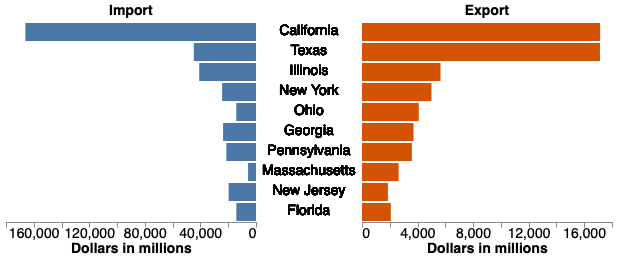

In [11]:
import altair as alt

# source = trade_china_tidy[trade_china_tidy.State !='UNITED STATES']

source = trade_china[trade_china.State !='UNITED STATES']

slider = alt.binding_range(min = 2008, max = 2018, step = 1)
select_year =alt.selection_single(name = "year", fields = ['Year'], 
                                 bind = slider, init = {'year': 2000}
                                 )



# base
base = alt.Chart(source).add_selection(
    select_year
).transform_filter(
    select_year
).transform_filter(
    alt.FieldOneOfPredicate(field='State', oneOf=top10_states)
).properties(
    width = 250
)

# color 
color_scale = alt.Scale(domain = ['export_normalized', 'import_normalized'], range = ['#1f77b4', '#e377c2'])


# left panel
left = base.encode(
    y = alt.Y('State:N', 
              sort = alt.EncodingSortField(field="export_normalized", order = 'descending'),
#               sort = alt.SortField(field = 'Dollars', order = 'descending'),
              axis = None),
    x = alt.X('import_normalized:Q',  
              title = 'Dollars in millions', 
              sort = alt.SortOrder('descending'), 
              scale=alt.Scale(domain=[0, 180000])
#               axis = None
             ),
    tooltip = ['State:N', 'import_normalized:Q']
).mark_bar().properties(title = 'Import')


# middle panel
middle = base.encode(
    y = alt.Y('State:N', 
              sort = alt.EncodingSortField(field="export_normalized", order = 'descending'),
#               sort = alt.SortField(field = 'Dollars', order = 'descending'),
              axis = None),
    text = alt.Text('State:N'),
).mark_text().properties(width = 90)


# right panel
right = base.encode(
    y = alt.Y('State:N', axis = None,
              sort = alt.EncodingSortField(field="export_normalized", order = 'descending'),
#              sort = alt.SortField(field = 'Dollars', order = 'descending'),
             ),
    x = alt.X('export_normalized:Q', 
              title = 'Dollars in millions', 
              scale=alt.Scale(domain=[0, 18000])
#               axis = None
#               sort = alt.SortOrder('ascending'), 
              
             ),
#     color = alt.Color('Year', scale = alt.Scale(scheme='accent'))
    color=alt.value('#D35400'), 
    tooltip = ['State:N', 'export_normalized:Q']
).mark_bar().properties(title = 'Export')


# 
# alt.renderers.enable('notebook')
alt.themes.enable('default')
alt.hconcat(
    left, middle, right, spacing = 5
).configure_axis(
    grid = False
).configure_view(
    strokeWidth = 0
)

### All States

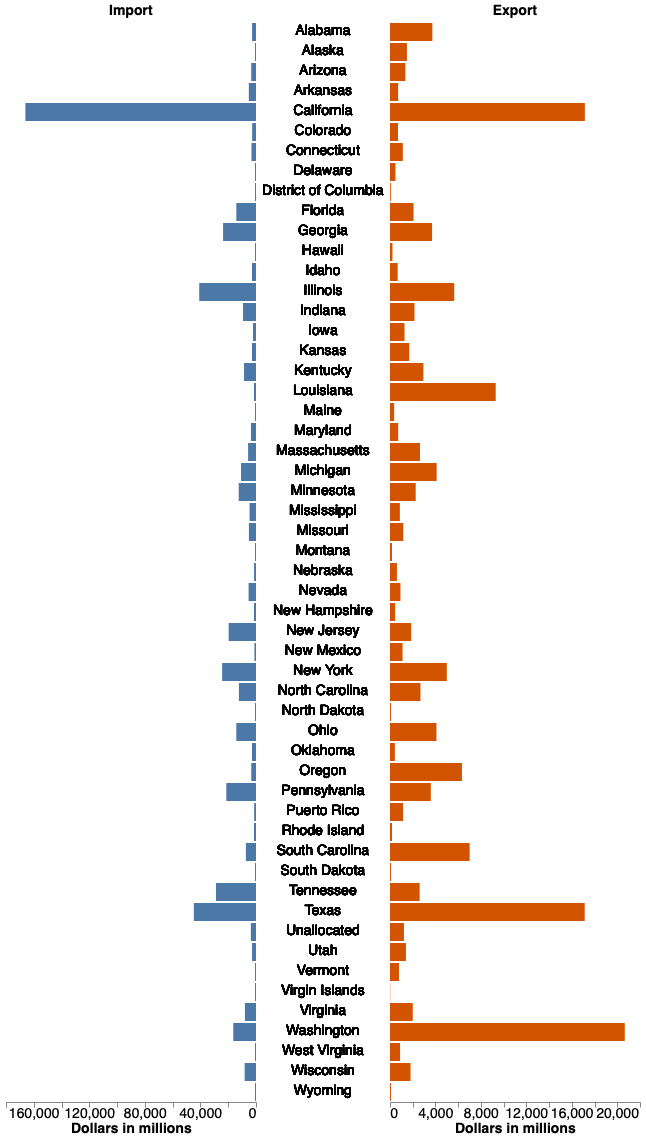

In [13]:
import altair as alt

# source = trade_china_tidy[trade_china_tidy.State !='UNITED STATES']

source = trade_china[trade_china.State !='UNITED STATES']

slider = alt.binding_range(min = 2008, max = 2018, step = 1)
select_year =alt.selection_single(name = "year", fields = ['Year'], 
                                 bind = slider, init = {'year': 2000}
                                 )




# base
base = alt.Chart(source).add_selection(
    select_year
).transform_filter(
    select_year
).transform_filter(
    alt.datum.export_normalized > 0
).properties(
    width = 250
)

# color 
color_scale = alt.Scale(domain = ['export_normalized', 'import_normalized'], range = ['#1f77b4', '#e377c2'])


# left panel
left = base.encode(
    y = alt.Y('State:N', 
#               sort = alt.SortField(field = 'Dollars', order = 'descending'),
              axis = None),
    x = alt.X('import_normalized:Q', 
              title = 'Dollars in millions', 
              sort = alt.SortOrder('descending'), 
#               axis = None
             ),
    tooltip = ['State:N', 'export_normalized:Q']
).mark_bar().properties(title = 'Import')


# middle panel
middle = base.encode(
    y = alt.Y('State:N', 
#               sort = alt.SortField(field = 'Dollars', order = 'descending'),
              axis = None),
    text = alt.Text('State:N'),
).mark_text().properties(width = 90)


# right panel
right = base.encode(
    y = alt.Y('State:N', axis = None, 
              
#              sort = alt.SortField(field = 'Dollars', order = 'descending'),
             ),
    x = alt.X('export_normalized:Q', 
              title = 'Dollars in millions', 
#               axis = None
#               sort = alt.SortOrder('ascending'), 
              
             ),
#     color = alt.Color('Year', scale = alt.Scale(scheme='accent'))
    color=alt.value('#D35400'), 
    tooltip = ['State:N', 'export_normalized:Q']
).mark_bar().properties(title = 'Export')


# 
# alt.renderers.enable('notebook')
alt.themes.enable('default')
alt.hconcat(
    left, middle, right, spacing = 5
).configure_axis(
    grid = False
).configure_view(
    strokeWidth = 0
)

## Choropleth map showing regional difference in U.S.exports to China 

/Users/dongliang/anaconda3/envs/ai/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/dongliang/anaconda3/envs/ai/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


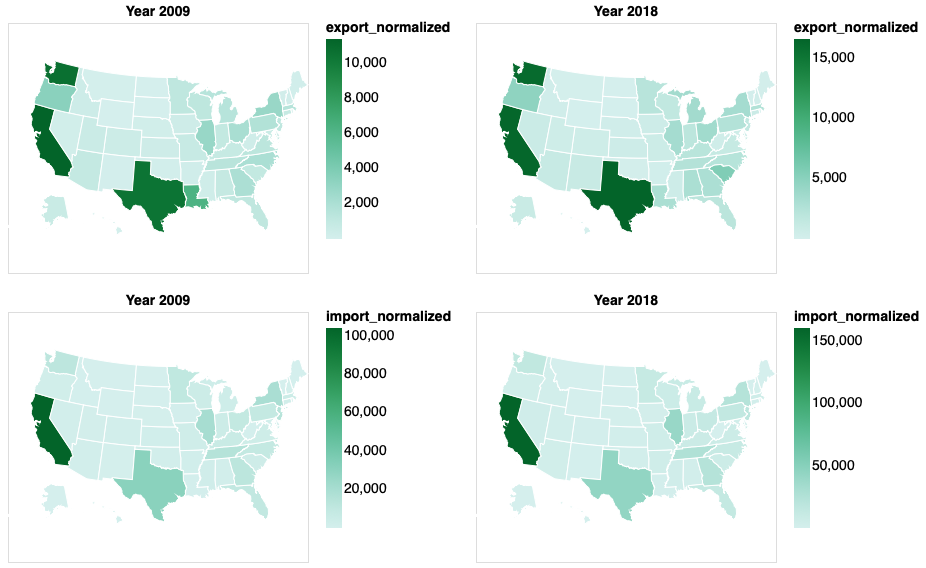

In [14]:
import altair as alt
from vega_datasets import data

keys = pd.read_csv('https://vega.github.io/vega-datasets/data/population_engineers_hurricanes.csv')
keys.set_index('state', inplace = True)

data_trade = trade_china[trade_china.State !='UNITED STATES']
data_trade['id'] = keys.loc[data_trade['State']]['id'].values.astype(int)
# data_trade.head()


def plot_choropleth(source, title, scheme): 

  states = alt.topo_feature(data.us_10m.url, 'states')
  variable_list = ['export_normalized', 'import_normalized']
  
  # selection
  slider = alt.binding_range(min = 2008, max = 2018, step = 1)
  select_year =alt.selection_single(name = "year", fields = ['Year'], 
                                   bind = slider, init = {'year': 2000}
                                   )


  plot = alt.Chart(states, title = title).mark_geoshape(stroke= 'white', strokeWidth=1).encode(
      alt.Color(alt.repeat('row'), 
                type='quantitative', 
                scale=alt.Scale(scheme=scheme)), 
      tooltip = ['State:N']
  ).transform_lookup(
      lookup='id',
      from_=alt.LookupData(source, 'id', variable_list + ['State'] )
  ).properties(
      width=300,
      height=250
  ).project(
      type='albersUsa'
  ).repeat(
      row=variable_list
  ).resolve_scale(
      color='independent'
  )

  return plot
  
  
source1 = data_trade[data_trade.Year==2009]  
source2 = data_trade[data_trade.Year==2018]  
plot_choropleth(source1, 'Year 2009', 'bluegreen') | plot_choropleth(source2, 'Year 2018', 'bluegreen') 


/Users/dongliang/anaconda3/envs/ai/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/dongliang/anaconda3/envs/ai/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


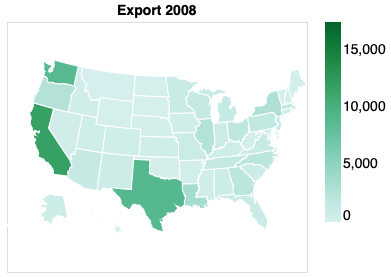

In [15]:
import altair as alt
from vega_datasets import data

keys = pd.read_csv('https://vega.github.io/vega-datasets/data/population_engineers_hurricanes.csv')
keys.set_index('state', inplace = True)

data_trade = trade_china[trade_china.State !='UNITED STATES']
data_trade['id'] = keys.loc[data_trade['State']]['id'].values.astype(int)
# data_trade.head()


def plot_choropleth(source, color_encoding, title, scheme, domain): 

  states = alt.topo_feature(data.us_10m.url, 'states')
  variable_list = ['export_normalized', 'import_normalized']
  
  # selection
  slider = alt.binding_range(min = 2008, max = 2018, step = 1)
  select_year =alt.selection_single(name = "year", fields = ['Year'], 
                                   bind = slider, init = {'year': 2000}
                                   )


  plot = alt.Chart(states, title = title).mark_geoshape(stroke= 'white', strokeWidth=1).encode(
      alt.Color(color_encoding, title = '',
                scale=alt.Scale(scheme=scheme, domain=domain)), 
      tooltip = ['State:N']
  ).transform_lookup(
      lookup='id',
      from_=alt.LookupData(source, 'id', variable_list + ['State'] )
  ).properties(
      width=300,
      height=250
  ).project(
      type='albersUsa'
  ).resolve_scale(
      color='independent'
  )

  return plot
  
  
source1 = data_trade[data_trade.Year==2008]  
source2 = data_trade[data_trade.Year==2018]  
# (plot_choropleth(source1, 'export_normalized:Q', 'Year 2008') | plot_choropleth(source2, 'export_normalized:Q', 'Year 2018') ) & (plot_choropleth(source1, 'import_normalized:Q', 'Year 2009') | plot_choropleth(source2, 'import_normalized:Q', 'Year 2018') )
plot_choropleth(source1, 'export_normalized:Q', 'Export 2008', 'bluegreen', [0, 17500]) 

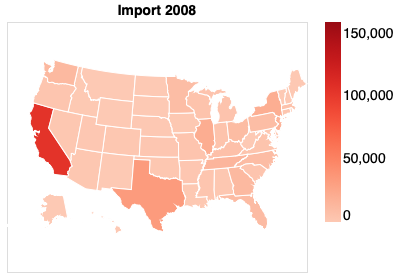

In [16]:
plot_choropleth(source1, 'import_normalized:Q', 'Import 2008', 'reds', [0, 160000]) 

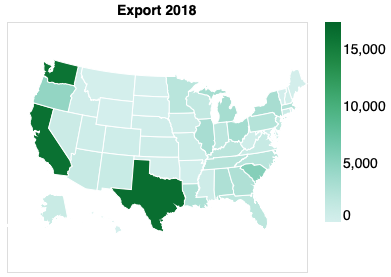

In [17]:
plot_choropleth(source2, 'export_normalized:Q', 'Export 2018', 'bluegreen', [0, 17500]) 

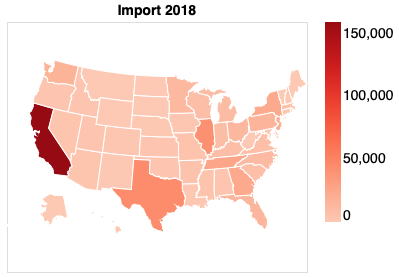

In [18]:
plot_choropleth(source2, 'import_normalized:Q', 'Import 2018', 'reds', [0, 160000]) 

In [ ]:

# import altair as alt
# from vega_datasets import data

# states = alt.topo_feature(data.us_10m.url, 'states')
# source = data_trade#[data_trade.Year==2010]
# variable_list = ['export_normalized', 'import_normalized']

# # selection
# slider = alt.binding_range(min = 2008, max = 2018, step = 1)
# select_year =alt.selection_single(name = "year", fields = ['Year'], 
#                                  bind = slider, init = {'year': 2000}
#                                  )


# alt.Chart(source).add_selection(
#   select_year
# ).transform_filter(
#   select_year
# ).transform_lookup(
#     lookup='id',
#     from_=alt.LookupData(states, 'id', ["type", "arcs"])
# ).mark_geoshape().encode(
#     alt.Color(alt.repeat('row'), type='quantitative')
# ).properties(
#     width=500,
#     height=300
# ).project(
#     type='albersUsa'
# ).repeat(
#     row=variable_list
# ).resolve_scale(
#     color='independent'
# )

## Export and export fractions of the top 10 U.S. states in 2018;

In [20]:
top10 = ['California' , 'Texas' , 'New York',  'Florida' , 'Illinois' , 'Pennsylvania' , 'Ohio',  'New Jersey', 'Georgia' , 'Massachusetts']

In [21]:
trade_china_2018 = trade_china.query('Year == 2018') 
trade_world_2018 = trade_world.query('Year == 2018') 

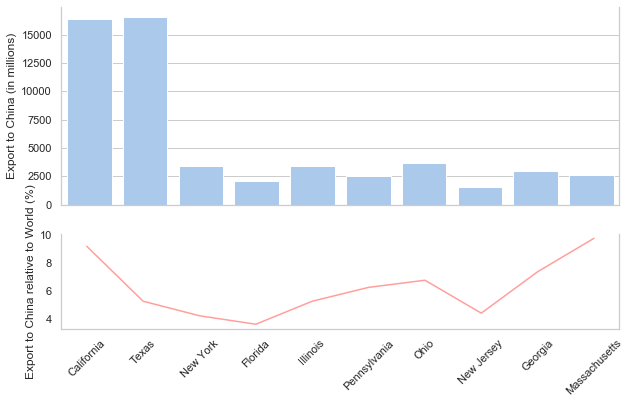

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt


# Top 10 states with highest GPD 
# df_export_china = trade_china_2018.loc[trade_china_2018.State != 'UNITED STATES'].sort_values('export_normalized', ascending = False)
# df_export_china_top10 = df_export_china.iloc[:10, :]

df_export_china = trade_china_2018.loc[trade_china_2018.State != 'UNITED STATES'] # .sort_values('export_normalized', ascending = False)
df_export_china.set_index('State',inplace = True)
df_export_china_top10 = df_export_china.loc[top10]


export_percent = 100* trade_china_2018.set_index(['State', 'Year'])['export_normalized'] \
                  / trade_world_2018.set_index(['State', 'Year'])['export_normalized']
# export_percent = export_percent.reset_index().sort_values('export_normalized', ascending = False).iloc[:10, :] #.loc[df_export.State != 'UNITED STATES']
export_percent = export_percent.reset_index()
# export_percent_top10 = export_percent[export_percent.State.isin(state_top10)]


# merge
df_export = pd.merge(df_export_china_top10, export_percent, how = 'left', on = 'State')




# settings for seaborn plotting 
sns.set(style="whitegrid", palette="pastel", color_codes=True)
# fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Export shown as barplot

plt.gcf().set_size_inches(10, 8)
plt.subplot(2,1,1)
ax1 = sns.barplot('State', 'export_normalized_x',
                  data = df_export ,
#                   order = [3,5,7],
                  label="Export ", color="b"
                )
plt.gca().set_xticklabels('')
plt.ylabel('Export to China (in millions)')
plt.xlabel('')



# Percentage of export shown as lineplot
plt.subplot(4,1,3)
# plt.twinx()
plt.plot('State', 'export_normalized_y',
                   data = df_export, #  style_order = top10,
                  label="Export (%)", color="r", # ax = ax2
                  )
plt.ylabel('Export to China relative to World (%)')
plt.grid(b=None)
plt.xticks(rotation = 45)



# plt.subplot(2,1,2)
# ax1 = sns.barplot('State', 'import_normalized',
#                   data = df_export ,
#                   label="Export ", color="b"
#                 )
# plt.xticks(rotation = 45)
# plt.ylabel('Import to US (in millions)')
# plt.xlabel('States')



# turn off grid
# ax1.grid(False)
# ax2.grid(False)

# remove top axes spine
sns.despine(top=True, right = False)


## Political orientation based on the presidential election result of 2016

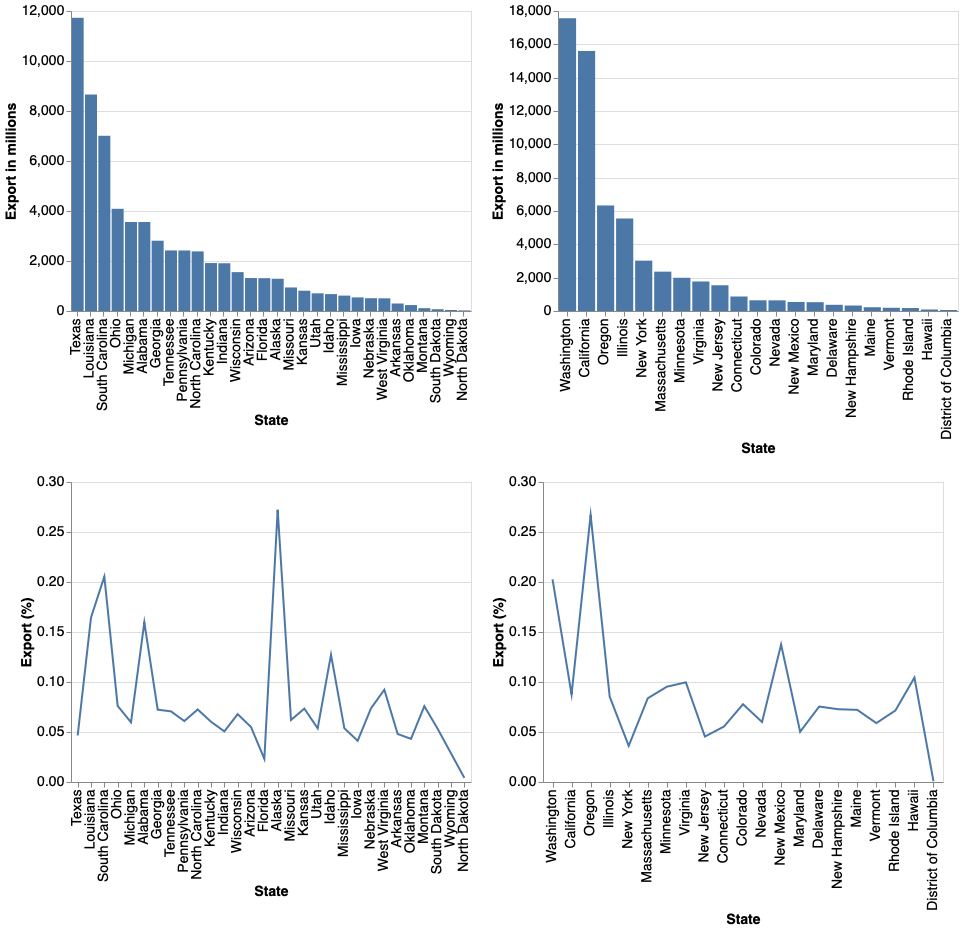

In [24]:
trade_china_2016 = trade_china.query('Year == 2016') 
trade_world_2016 = trade_world.query('Year == 2016') 
export_percent_2016 = (trade_china_2016.set_index(['State', 'Year'])['export_normalized'] \
                  / trade_world_2016.set_index(['State', 'Year'])['export_normalized']).reset_index() 

export_percent_2016.rename(columns = {'export_normalized': 'export_normalized_perc'}, inplace = True)


# base plot
base = alt.Chart(trade_china_2016).encode(
    alt.X('State:N', 
          sort = alt.EncodingSortField(field="export_normalized", order = 'descending')), 
).transform_filter(
  alt.datum.State != 'UNITED STATES'
).transform_lookup(
  lookup = 'State', from_ = alt.LookupData(election, 'State', ['Party'])
).transform_lookup(
  lookup = 'State', from_ = alt.LookupData(export_percent_2016, 'State', ['export_normalized_perc'])
).properties(
  width = 400
)


# Republic
republic_bar = base.mark_bar().encode(
    alt.Y('export_normalized:Q', 
        title = 'Export in millions'),
#   order=alt.Order('export_normalized', sort='ascending')
).transform_filter(
  alt.datum.Party == 'Republican'
)


republic_line = base.mark_line().encode(
    alt.Y('export_normalized_perc:Q', title = 'Export (%)')
).transform_filter(
  alt.datum.Party == 'Republican'
)


# Democratic
democratic_bar = base.mark_bar().encode(
  alt.Y('export_normalized:Q', title = 'Export in millions'),
).transform_filter(
  alt.datum.Party == 'Democratic'
)


democratic_line = base.mark_line().encode(
  alt.Y('export_normalized_perc:Q', title = 'Export (%)')
).transform_filter(
  alt.datum.Party == 'Democratic'
)



# Combine 
(republic_bar | democratic_bar) & (republic_line | democratic_line)

In [25]:
trade_china_2016 = trade_china.query('Year == 2016') 
trade_world_2016 = trade_world.query('Year == 2016') 
export_percent_2016 = (trade_china_2016.set_index(['State', 'Year'])['export_normalized'] \
                  / trade_world_2016.set_index(['State', 'Year'])['export_normalized']).reset_index() 

export_percent_2016.rename(columns = {'export_normalized': 'export_normalized_perc'}, inplace = True)
# trade_china_2016.dropna(subset = 'Party')


df_ = pd.merge(trade_china_2016, election, how = 'left', on = 'State')
df = pd.merge(df_, export_percent_2016, how = 'left', on = 'State')
df.dropna(subset=['Party'], inplace = True)


# base plot
base = alt.Chart(df).encode(
    alt.X( 'Party:N' )
).transform_filter(
  alt.datum.State != 'UNITED STATES'
).properties(
  width = 400
)


bar = base.mark_bar().encode(
    alt.Y('export_normalized:Q', aggregate='sum', 
        title = 'Export in millions'),  
    tooltip = ['State:N'], 
#     color = 'State:N'
)


# line = base.mark_line().encode(
#     alt.Y('export_normalized_perc:Q', title = 'Export (%)')
# ).transform_aggregate( 
#     percent='' 
# )


# # Republic
# republic_bar = base.mark_bar().encode(
#     alt.Y('export_normalized:Q', 
#         title = 'Export in millions'),
# #   order=alt.Order('export_normalized', sort='ascending')
# ).transform_filter(
#   alt.datum.Party == 'Republican'
# )


# republic_line = base.mark_line().encode(
#     alt.Y('export_normalized_perc:Q', title = 'Export (%)')
# ).transform_filter(
#   alt.datum.Party == 'Republican'
# )


# # Democratic
# democratic_bar = base.mark_bar().encode(
#   alt.Y('export_normalized:Q', title = 'Export in millions'),
# ).transform_filter(
#   alt.datum.Party == 'Democratic'
# )


# democratic_line = base.mark_line().encode(
#   alt.Y('export_normalized_perc:Q', title = 'Export (%)')
# ).transform_filter(
#   alt.datum.Party == 'Democratic'
# )



# # Combine 
# (republic_bar | democratic_bar) & (republic_line | democratic_line)

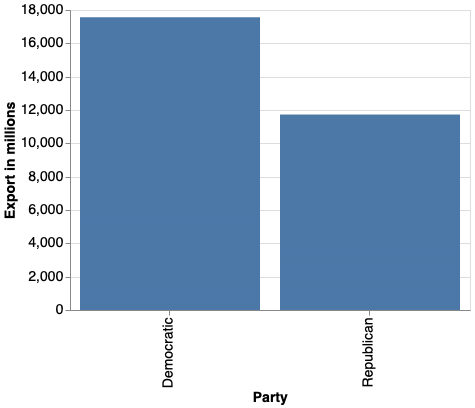

In [26]:
bar

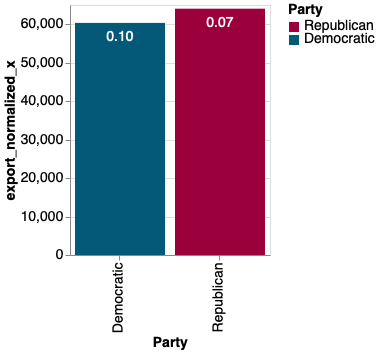

In [27]:
trade_china_2016 = trade_china.query('Year == 2016') 
trade_world_2016 = trade_world.query('Year == 2016') 

def myMerge(left, election):
    df = pd.merge(left, election, how = 'left', on = 'State')
    df.dropna(subset=['Party'], inplace = True)
    df_agg = df.groupby('Party').agg(['sum'])[['export_normalized']].reset_index()
    df_agg.columns = ['Party', 'export_normalized']
    return df_agg


source_china = myMerge(trade_china_2016, election)
source_world = myMerge(trade_world_2016, election)
source = pd.merge(source_china, source_world, on = 'Party', )
source = source.assign(ratio = lambda x: x.iloc[:,1]/x.iloc[:, 2] )
source


bar = alt.Chart(source).mark_bar().encode(
    x = 'Party:N', 
    y = 'export_normalized_x:Q', 
    color = alt.Color('Party:N', 
                     scale = alt.Scale(domain = ['Republican', 'Democratic'], 
                                      range = ['#9C003C', '#045979', '#7BAABD']
                                      )
                     )
).properties(
  width = 200, 
  height = 250  
)


text = alt.Chart(source).mark_text(dx=0, dy=15, color='white').encode(
    x=alt.X('Party:N'),
    y=alt.Y('export_normalized_x:Q'),
    detail='Party:N',
    text=alt.Text('ratio:Q', format='.2f')
)

bar + text

## Time Series of Export, Import and Surplus/Deficit

### Data pre-processing

In [ ]:
# only select state data

# export_china = export_china.iloc[1:, ] 
# import_china = import_china.iloc[1:, ]
# export_world = export_world.iloc[1:, ]

In [28]:
# melt the data into tidy data format for import and export

df_export_china = export_china.melt(id_vars=["State"], var_name="Year", value_name="Export")
df_import_china = import_china.melt(id_vars=["State"], var_name="Year", value_name="Import")
df_trade_china = pd.merge(df_export_china, df_import_china, how='inner', on=['Year', 'State'])
df_trade_china = df_trade_china[~df_trade_china.State.isin(['Virgin Islands', 'Puerto Rico', 'Unallocated'])]
df_trade_china['Surplus'] = df_trade_china.eval('Export - Import')

# conver the value to million dollars
df_trade_china['Export'] = np.round(df_trade_china['Export']/1e6)
df_trade_china['Import'] = np.round(df_trade_china['Import']/1e6)
df_trade_china['Surplus'] = np.round(df_trade_china['Surplus']/1e6)

df_trade_china.Year = df_trade_china.Year.astype('int') # convert Year to integer

df_trade_china.head()

State  Year   Export    Import   Surplus
0   UNITED STATES  2008  69733.0  337773.0 -268040.0
1           Texas  2008   8422.0   31906.0  -23485.0
2      California  2008  10982.0   98676.0  -87695.0
3      Washington  2008   8310.0   11343.0   -3033.0
4  South Carolina  2008    790.0    3568.0   -2778.0

In [34]:
# melt the data into tidy data format for export and percent export 

df_export_world = export_world.melt(id_vars=["State"], var_name="Year", value_name="Export to World")
df_export = pd.merge(df_export_china, df_export_world, how='inner', on=['Year', 'State'])
df_export = df_export[~df_export.State.isin(['Virgin Islands', 'Puerto Rico', 'Unallocated'])]
df_export.rename(columns={'Export':'Export to China'}, inplace=True)
df_export['Percent of Export to China'] = df_export['Export to China']/df_export['Export to World']

# conver the value to million dollars
df_export['Export to China'] = np.round(df_export['Export to China']/1e6)
df_export['Export to World'] = np.round(df_export['Export to World']/1e6)

df_export['Percent of Export to China'] = df_export['Percent of Export to China']

df_export.head()

State  Year  Export to China  Export to World  \
0   UNITED STATES  1999          13118.0         692821.0   
1           Texas  1999            900.0          83177.0   
2      California  1999           2395.0          97920.0   
3      Washington  1999           2040.0          36731.0   
4  South Carolina  1999            139.0           7150.0   

   Percent of Export to China  
0                    0.018934  
1                    0.010817  
2                    0.024456  
3                    0.055552  
4                    0.019444

In [30]:
# min percent of export to china in total export
df_export['Percent of Export to China'].min()

0.0007338530382185293

In [31]:
# max percent of export to china in total export
df_export['Percent of Export to China'].max()

0.3023246211198641

convert the data to dollar value in 2018

In [35]:
# convert df_trade_china
# we don't need to convert df_export b/c we are only interested in percent of export

df_trade_china = pd.merge(df_trade_china, ppi_year_2018, how='left', on='Year')
df_trade_china.Export = df_trade_china.eval('Export/PPIACO')
df_trade_china.Import = df_trade_china.eval('Import/PPIACO')
df_trade_china.Surplus = df_trade_china.eval('Surplus/PPIACO')

# keep one copy of unmelted df_trade_china
df_trade_china_copy = df_trade_china.copy()

df_trade_china.head()

State  Year        Export         Import        Surplus  PPIACO_x  \
0   UNITED STATES  2008  79120.236312  383242.934907 -304122.698595  0.938805   
1           Texas  2008   9555.743052   36201.084992  -26646.476558  0.938805   
2      California  2008  12460.362170  111959.451599  -99500.224046  0.938805   
3      Washington  2008   9428.665965   12869.958850   -3441.292885  0.938805   
4  South Carolina  2008    896.347306    4048.312896   -3151.965590  0.938805   

   PPIACO_y    PPIACO  
0  0.938805  0.938805  
1  0.938805  0.938805  
2  0.938805  0.938805  
3  0.938805  0.938805  
4  0.938805  0.938805

In [36]:
# melt the data into tidy data format for import and export

df_trade_china = df_trade_china.drop(columns=['PPIACO'])
df_trade_china = df_trade_china.melt(id_vars=["State", "Year"], var_name="Category", value_name="Trade, in Million Dollars")
df_trade_china['Trade, in Million Dollars'] = df_trade_china['Trade, in Million Dollars'].astype(int) # convert to integer
df_trade_china.head()

State  Year Category  Trade, in Million Dollars
0   UNITED STATES  2008   Export                      79120
1           Texas  2008   Export                       9555
2      California  2008   Export                      12460
3      Washington  2008   Export                       9428
4  South Carolina  2008   Export                        896

### Export,  Import and Surplus/Deficit

Interactive Plots

In [37]:
df_trade_china.State.unique()

array(['UNITED STATES', 'Texas', 'California', 'Washington',
       'South Carolina', 'Oregon', 'Ohio', 'Michigan', 'New York',
       'Illinois', 'Louisiana', 'Alabama', 'Georgia', 'Massachusetts',
       'Pennsylvania', 'Tennessee', 'North Carolina', 'Minnesota',
       'Kentucky', 'Florida', 'Indiana', 'Wisconsin', 'New Jersey',
       'Virginia', 'Arizona', 'New Mexico', 'Alaska', 'Connecticut',
       'Nevada', 'Missouri', 'Kansas', 'Mississippi', 'Iowa', 'Maryland',
       'Colorado', 'Utah', 'West Virginia', 'Nebraska', 'Idaho',
       'Delaware', 'New Hampshire', 'Arkansas', 'Maine', 'Oklahoma',
       'Vermont', 'Rhode Island', 'Montana', 'Wyoming', 'South Dakota',
       'Hawaii', 'North Dakota', 'District of Columbia'], dtype=object)

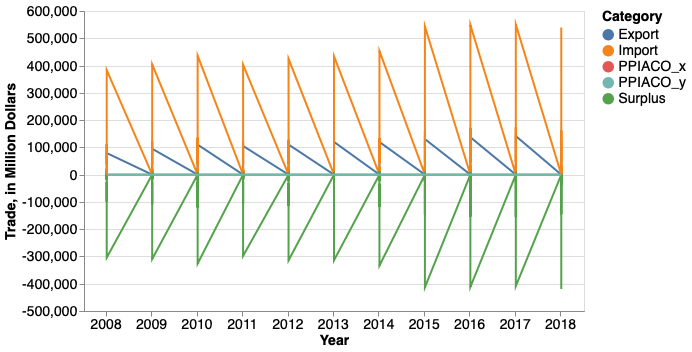

In [38]:
import altair as alt

states = list(df_trade_china.State.unique())
input_dropdown = alt.binding_select(options=states)
select_state = alt.selection_single(name='Select', fields=['State'],
                                   bind=input_dropdown)

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Year'], empty='none')

# The basic line
base = alt.Chart(df_trade_china).encode(
    alt.X('Year:O'),
    alt.Y('Trade, in Million Dollars:Q'),
    color='Category:N'
).transform_filter(select_state)

# add drop-down menu
lines = base.mark_line().add_selection(select_state
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(df_trade_china).mark_point().encode(
    x='Year:O',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = base.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = base.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Trade, in Million Dollars:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(df_trade_china).mark_rule(color='gray').encode(
    x='Year:O',
).transform_filter(
    nearest
)

#Put the five layers into a chart and bind the data
alt.layer(
    lines, selectors, points, rules, text
).properties(
    width=500, height=300
).configure_axisX(
    labelAngle=0
).configure_axis(
    titleFontSize=12.5,
    labelFontSize=12.5
).configure_legend(
    titleFontSize=12.5,
    labelFontSize=12.5
)


Summary of Export, Import and Surplus/Deficit:

* States that have increase in both import and export and relatively stable surplus/deficit:
  *  Texas, South Carolina, Michigan, Alabama, Indiana, Nevada, Colorado and Utah, Nebraska, Delaware, Maine, Montana, Wyoming, 
* States that having stable import and increasing export:
  * Kentucky, Ohio, 
* States that having stable export and increasing import:
  * Florida, Wisconsin, New Jersey, Virginia, Arizona, Missouri, Mississippi, Maryland, Idaho, New Hampshire, Arkansas, Oklahoma, South Dakota, North Dakota, California, Illinois, Georgia, , Pennsylvania, Tennessee, North Carolina, Minnesota, 
* States that have stable/constant import and export:
  * New York, Massachusetts, Rhode Island, Hawaii, Connecticut, 
* States that have unique trend:
  * Oregon and Alaska: overall increasing but up-and-down
  * Louisiana: import stable; export first increases and then decreases (sharply in 2018)
  * New Mexico: export first decreased then consistant for some time and then goes up
  * Kansas and Iow and Utah: import increasing, export first increasing then decreasing
  * West Virginia, Vermont: export first increases and then decreases, import relatively stable
  * DC: stable but sharp increase in import
  * Washington: import and export goes into opposite direction and changed direction in 2014


Static plots

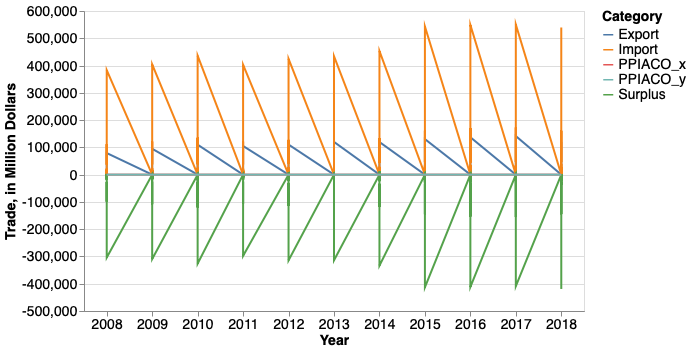

In [39]:
import altair as alt

states = list(df_trade_china.State.unique())
input_dropdown = alt.binding_select(options=states)
select_state = alt.selection_single(name='Select', fields=['State'],
                                   bind=input_dropdown)

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Year'], empty='none')

# The basic line
base = alt.Chart(df_trade_china).encode(
    alt.X('Year:O'),
    alt.Y('Trade, in Million Dollars:Q'),
    color='Category:N'
).transform_filter(select_state)

# add drop-down menu
lines = base.mark_line().add_selection(select_state
).properties(
    width=500, height=300
).configure_axisX(
    labelAngle=0
).configure_axis(
    titleFontSize=12.5,
    labelFontSize=12.5
).configure_legend(
    titleFontSize=12.5,
    labelFontSize=12.5
)

lines

In [ ]:
import altair as alt

states = list(df_trade_china.State.unique())
input_dropdown = alt.binding_select(options=states)
select_state = alt.selection_single(name='Select', fields=['State'],
                                   bind=input_dropdown)

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Year'], empty='none')

# The basic line
base = alt.Chart(df_trade_china).encode(
    alt.X('Year:O'),
    alt.Y('Trade, in Million Dollars:Q'),
    color=alt.Color('Category', legend=None),
).transform_filter(select_state)

# add drop-down menu
lines = base.mark_line().add_selection(select_state
).properties(
    width=500, height=300
).configure_axisX(
    labelAngle=0
).configure_axis(
    titleFontSize=12.5,
    labelFontSize=12.5
)

lines

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 12.5,
      titleFontSize: 12.5
    }),
    axisX: AxisConfig({
      labelAngle: 0
    })
  }),
  data:                      State  Year Category  Trade, in Million Dollars
  0            UNITED STATES  2008   Export                      74278
  1                    Texas  2008   Export                       8970
  2               California  2008   Export                      11697
  3               Washington  2008   Export                       8851
  4           South Carolina  2008   Export                        841
  5                   Oregon  2008   Export                       2629
  6                     Ohio  2008   Export                       1937
  7                 Michigan  2008   Export                       1371
  8                 New York  2008   Export                       2998
  9                 Illinois  2008   Export                       2676
  10               Louisiana  2008   Export                       3706
  11                 Alabama  2008   Export                        870
  12                 Georgia  2008   Export                       2132
  13           Massachusetts  2008   Export                       1664
  14            Pennsylvania  2008   Export                       1736
  15               Tennessee  2008   Export                       1452
  16          North Carolina  2008   Export                       2069
  17               Minnesota  2008   Export                       1088
  18                Kentucky  2008   Export                        643
  19                 Florida  2008   Export                        928
  20                 Indiana  2008   Export                        990
  21               Wisconsin  2008   Export                       1311
  22              New Jersey  2008   Export                       1044
  23                Virginia  2008   Export                       1239
  24                 Arizona  2008   Export                       1336
  25              New Mexico  2008   Export                        692
  26                  Alaska  2008   Export                        780
  27             Connecticut  2008   Export                        720
  28                  Nevada  2008   Export                        396
  29                Missouri  2008   Export                       1005
  ...                    ...   ...      ...                        ...
  1686            New Jersey  2018  Surplus                     -17131
  1687              Virginia  2018  Surplus                      -6472
  1688               Arizona  2018  Surplus                      -2209
  1689            New Mexico  2018  Surplus                        435
  1690                Alaska  2018  Surplus                        708
  1691           Connecticut  2018  Surplus                      -1358
  1692                Nevada  2018  Surplus                      -3049
  1693              Missouri  2018  Surplus                      -4117
  1694                Kansas  2018  Surplus                      -2199
  1695           Mississippi  2018  Surplus                      -3520
  1696                  Iowa  2018  Surplus                      -1474
  1697              Maryland  2018  Surplus                      -3005
  1698              Colorado  2018  Surplus                      -1430
  1699                  Utah  2018  Surplus                      -2150
  1700         West Virginia  2018  Surplus                        249
  1701              Nebraska  2018  Surplus                       -529
  1702                 Idaho  2018  Surplus                      -2467
  1703              Delaware  2018  Surplus                        -71
  1704         New Hampshire  2018  Surplus                       -699
  1705              Arkansas  2018  Surplus                      -4853
  1706                 Maine  2018  Surplus                       -146
  1707              Oklahoma  2018  Surplus                    

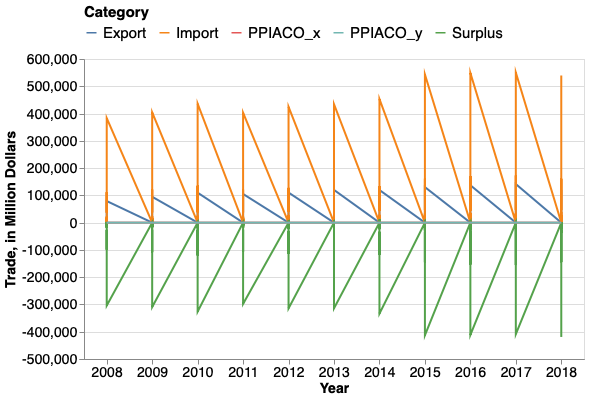

In [40]:
import altair as alt

states = list(df_trade_china.State.unique())
input_dropdown = alt.binding_select(options=states)
select_state = alt.selection_single(name='Select', fields=['State'],
                                   bind=input_dropdown)

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Year'], empty='none')

# The basic line
base = alt.Chart(df_trade_china).encode(
    alt.X('Year:O'),
    alt.Y('Trade, in Million Dollars:Q'),
    color=alt.Color('Category', legend=alt.Legend(orient="top")),
).transform_filter(select_state)

# add drop-down menu
lines = base.mark_line().add_selection(select_state
).properties(
    width=500, height=300
).configure_axisX(
    labelAngle=0
).configure_axis(
    titleFontSize=12.5,
    labelFontSize=12.5
).configure_legend(
    titleFontSize=15,
    labelFontSize=15
)

lines

### Export and Percent Export

Percent of Export in Total Export. Can show the numbers.

In [41]:
def singleY_chart(y):
    """
    A quick function to plot an interactive plot for a single Y
    
    Args:
        y(string):   the column name of y
    Return:
        chart:       an interative times-series plot
    """
    
    states = list(df_export.State.unique())
    input_dropdown = alt.binding_select(options=states)
    select_state = alt.selection_single(name='Select', fields=['State'],
                                   bind=input_dropdown)
  
    # Create a selection that chooses the nearest point & selects based on x-value
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                            fields=['Year'], empty='none')

    # The basic line
    base = alt.Chart(df_export).encode(
        alt.X('Year:O'),
        alt.Y(y, type='quantitative')
    ).transform_filter(select_state)

    # add drop-down menu
    line = base.mark_line().add_selection(select_state)

    # Transparent selectors across the chart. This is what tells us
    # the x-value of the cursor
    selectors = alt.Chart(df_export).mark_point().encode(
        x='Year:O',
        opacity=alt.value(0),
    ).add_selection(
        nearest
    )

    # Draw points on the line, and highlight based on selection
    points = base.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )

    # Draw text labels near the points, and highlight based on selection
    text = base.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, alt.Y(y, type='quantitative'), alt.value(' '))
    )

    # Draw a rule at the location of the selection
    rules = alt.Chart(df_export).mark_rule(color='gray').encode(
        x='Year:O',
    ).transform_filter(
        nearest
    )

    # Put the five layers into a chart and bind the data
    chart = alt.layer(
        line, selectors, points, rules, text
    ).properties(
        width=500, height=300
    ).configure_axisX(
        labelAngle=0
    ).configure_axis(
        titleFontSize=12.5,
        labelFontSize=12.5
    ).configure_legend(
        titleFontSize=12.5,
        labelFontSize=12.5
    )

    return chart
  
  

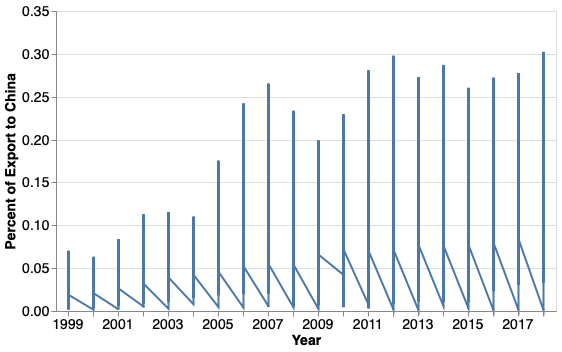

In [42]:
singleY_chart('Percent of Export to China')

* Louisinana: Big drop from 16.4% in 2016 to  4.3% in 2018
* New Mexico: increased from 2.5% before 2007 to 26.5% in 2007, dropped to 2.5% from 2011 to 2015 and then increased again to 30% in 2018
* Kansas, Arkansas and Utah: peak around 2013 and dropped to half (14% to 6%, 9.5% to 5% and 9% to 4%)
* Iowa: peak at 9% around 2015 and dropped to 4.5% after 2016
* Vermont: peak at 18% around 2011 then dropped to 7% after 2015
* Hawaii: bouncing up and down around 9%

Static Plot showing both export to China and percent of export to China in total export

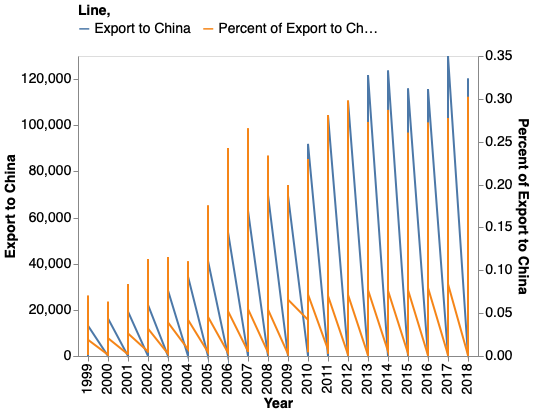

In [43]:
# 'line' and ' ' are created to force a layer grouped by label
# see https://github.com/altair-viz/altair/issues/984 for example
df_export['Line'] = 'Export to China'
df_export[' '] = 'Percent of Export to China'

states = list(df_export.State.unique())
input_dropdown = alt.binding_select(options=states)
select_state = alt.selection_single(name='Select', fields=['State'],
                                   bind=input_dropdown)

base = alt.Chart().encode(
    alt.X('Year:O', axis=alt.Axis(orient="bottom"))
).transform_filter(select_state)

line1 = base.mark_line().encode(
    alt.Y('Export to China', type='quantitative'),
    color=alt.Color('Line', legend=alt.Legend(orient="top"))).add_selection(select_state)

line2 = base.mark_line().encode(
    alt.Y('Percent of Export to China', type='quantitative'),
    color=' ')

vline = alt.Chart().mark_rule(color='red'
            ).encode(alt.X('Year:O')
            ).transform_filter(alt.datum.Year == '2001')

alt.layer(
    line1,
    line2,
#     vline,
    data=df_export
).resolve_scale(
    y='independent'
).configure_legend(
    titleFontSize=12.5,
    labelFontSize=12.5
)

### Test Case with Aritificial Data

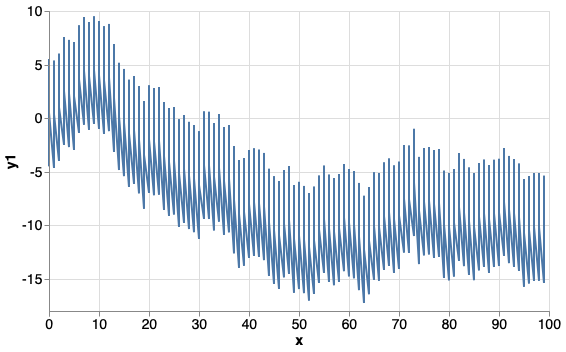

In [44]:
import altair as alt
import pandas as pd
import numpy as np

np.random.seed(42)
source = pd.DataFrame(np.cumsum(np.random.randn(100, 1), 0).round(2),
                    columns=['A'], index=pd.RangeIndex(100, name='x'))
source = source.reset_index().melt('x', var_name='category', value_name='y1')
source['Type'] = 'First'

source_1 = source.copy()
source_1['y1'] = source_1['y1'] + 5
source_1['Type'] = 'Second'

source_2 = source.copy()
source_2['y1'] = source_2['y1'] - 5
source_2['Type'] = 'Third'

source = pd.concat([source, source_1, source_2])

source['y2'] = source['y1']/10

def singleY_chart(y):
  
    input_dropdown = alt.binding_select(options=['First', 'Second', 'Third'])
    selection = alt.selection_single(name='Select', fields=['Type'],
                                       bind=input_dropdown)

    # Create a selection that chooses the nearest point & selects based on x-value
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                            fields=['x'], empty='none')

    # The basic line
    base = alt.Chart(source).encode(
        alt.X('x:Q'),
        alt.Y(y, type='quantitative')
    ).transform_filter(selection)

    # add drop-down menu
    line = base.mark_line().add_selection(selection)

    # Transparent selectors across the chart. This is what tells us
    # the x-value of the cursor
    selectors = alt.Chart(source).mark_point().encode(
        x='x:Q',
        opacity=alt.value(0),
    ).add_selection(
        nearest
    )

    # Draw points on the line, and highlight based on selection
    points = base.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )

    # Draw text labels near the points, and highlight based on selection
    text = base.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, alt.Y(y, type='quantitative'), alt.value(' '))
    )

    # Draw a rule at the location of the selection
    rules = alt.Chart(source).mark_rule(color='gray').encode(
        x='x:Q',
    ).transform_filter(
        nearest
    )

    # Put the five layers into a chart and bind the data
    chart = alt.layer(
        line, selectors, points, rules, text
    ).properties(
        width=500, height=300
    ).configure_axisX(
        labelAngle=0
    ).configure_axis(
        titleFontSize=12.5,
        labelFontSize=12.5
    ).configure_legend(
        titleFontSize=12.5,
        labelFontSize=12.5
    )

    return chart
  

singleY_chart('y1')

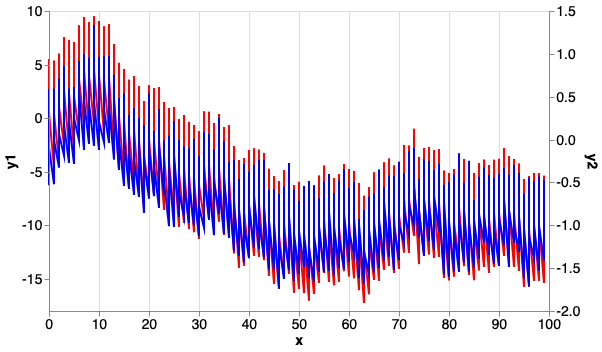

In [45]:
import altair as alt
import pandas as pd
import numpy as np

np.random.seed(42)
source = pd.DataFrame(np.cumsum(np.random.randn(100, 1), 0).round(2),
                    columns=['A'], index=pd.RangeIndex(100, name='x'))
source = source.reset_index().melt('x', var_name='category', value_name='y1')
source['Type'] = 'First'

source_1 = source.copy()
source_1['y1'] = source_1['y1'] + 5
source_1['Type'] = 'Second'

source_2 = source.copy()
source_2['y1'] = source_2['y1'] - 5
source_2['Type'] = 'Third'

source = pd.concat([source, source_1, source_2])

source['y2'] = source['y1']/10 + np.random.randn(300, )/10

def singleY_chart():

    input_dropdown = alt.binding_select(options=['First', 'Second', 'Third'])
    selection = alt.selection_single(name='Select', fields=['Type'],
                                       bind=input_dropdown)

    # Create a selection that chooses the nearest point & selects based on x-value
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                            fields=['x'], empty='none')

    # The basic line
    base = alt.Chart(source).encode(
        alt.X('x:Q')
    ).transform_filter(selection)

    # add drop-down menu
    line_1 = base.mark_line().encode(alt.Y('y1'),
                              color=alt.value('red')).add_selection(selection)

    line_2 = base.mark_line().encode(alt.Y('y2'),
                              color=alt.value('blue'))

    # Transparent selectors across the chart. This is what tells us
    # the x-value of the cursor
    selectors = alt.Chart(source).mark_point().encode(
        x='x:Q',
        opacity=alt.value(0),
    ).add_selection(
        nearest
    )

    # Draw points on the line, and highlight based on selection
    points = base.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )

    # Draw text labels near the points, and highlight based on selection
    text = base.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, alt.Y('y2:Q'), alt.value(' '))
    )

    # Draw a rule at the location of the selection
    rules = alt.Chart(source).mark_rule(color='gray').encode(
        x='x:Q',
    ).transform_filter(
        nearest
    )

    # Put the five layers into a chart and bind the data
    chart = alt.layer(
        line_1, line_2, selectors, points, rules, text 
    ).resolve_scale(
    y='independent'
    ).properties(
        width=500, height=300
    ).configure_axisX(
        labelAngle=0
    ).configure_axis(
        titleFontSize=12.5,
        labelFontSize=12.5
    ).configure_legend(
        titleFontSize=12.5,
        labelFontSize=12.5
    )

    return chart


singleY_chart()

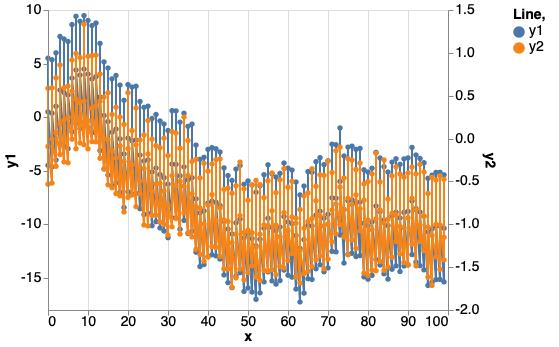

In [46]:
source['Line'] = 'y1'
source[' '] = 'y2'

input_dropdown = alt.binding_select(options=['First', 'Second', 'Third'])
selection = alt.selection_single(name='Type', fields=['Type'],
                                   bind=input_dropdown)

base = alt.Chart(source).encode(
    alt.X('x:Q')
).transform_filter(selection)

line1 = base.mark_line(point=True).encode(
    alt.Y('y1:Q'),
    color='Line').add_selection(selection)

line2 = base.mark_line(point=True).encode(
    alt.Y('y2:Q'),
    color=' ')

alt.layer(
    line1,
    line2
).resolve_scale(
    y='independent'
)

## Bar chart to show export and perent of Export in Different Regions

In [47]:
export_region = pd.merge(df_export.loc[df_export.Year == '2017', ['State', 'Export to China', 'Export to World']], gdp_2018[['State', 'region']], on='State', how ='left')
export_region.head()

State  Export to China  Export to World     region
0   UNITED STATES         129894.0        1546273.0        NaN
1           Texas          16419.0         264541.0  Southwest
2      California          16433.0         172012.0   Far West
3      Washington          17967.0          76414.0   Far West
4  South Carolina           6230.0          32199.0  Southeast

prepare the data for plotting 

In [48]:
export_region = export_region.groupby('region')[['Export to China', 'Export to World']].sum()
export_region = export_region.reset_index()
export_region['Percent of Export to China'] = export_region['Export to China']/export_region['Export to World']
export_region = export_region.sort_values('Export to World', ascending=False)
export_region['Export to China'] = np.round(export_region['Export to China']/1000, 1) # convert to billions
export_region['Export to World'] = np.round(export_region['Export to World']/1000, 1) # convert to billions
export_region

region  Export to China  Export to World  \
6       Southeast             33.4            340.7   
7       Southwest             18.8            294.4   
0        Far West             40.6            288.4   
1     Great Lakes             16.6            235.2   
2         Mideast              8.3            166.5   
4          Plains              4.8             73.9   
3     New England              4.1             55.4   
5  Rocky Mountain              1.8             26.3   

   Percent of Export to China  
6                    0.097901  
7                    0.063964  
0                    0.140736  
1                    0.070412  
2                    0.049739  
4                    0.065025  
3                    0.074542  
5                    0.070003

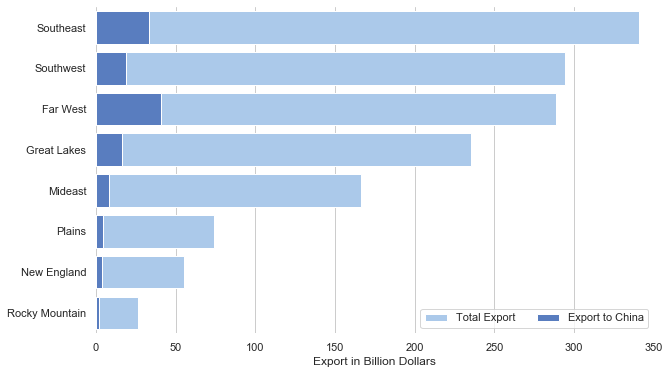

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# Plot the total export
sns.set_color_codes("pastel")
sns.barplot(x="Export to World", y="region", data=export_region,
            label="Total Export", color="b")

# Plot the export to China
sns.set_color_codes("muted")
sns.barplot(x="Export to China", y="region", data=export_region,
            label="Export to China", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 350), ylabel="",
       xlabel="Export in Billion Dollars")
sns.despine(left=True, bottom=True)

## Waffle chart to compare U.S. exports to major trading partners: (China, EU, Japan and NAFTA)

In [50]:
# Top 10 states in economic scale by GDP

top10_states = list(gdp_2018.sort_values('gdp', ascending=False).State.iloc[:10])
top10_states


['California',
 'Texas',
 'New York',
 'Florida',
 'Illinois',
 'Pennsylvania',
 'Ohio',
 'New Jersey',
 'Georgia',
 'Massachusetts']

Import the export data in 2018 for all states to 4 major economic entities: China, Japan, EU and NAFTA

In [51]:
export_to_world_2018 = pd.read_csv('DATA_Exports_to_World.csv')[['State', '2018']]
# export_to_world_2018.to_csv('Export_to_World_2018.csv')

In [52]:
def read_export_2018(region):
  """
  utility function for reading data and sort rows by state name
  """
  file_name = 'Export_to_' + region +'_2018.csv'
  df = pd.read_csv(file_name)
  df.rename(columns={'2018':(region + '_')}, inplace=True)
  df.sort_values('State', inplace=True)
  df.reset_index(drop=True, inplace=True)
  return df

export_2018 = {}

for region in ['China', 'Japan', 'EU', 'NAFTA', 'World']:
  export_2018[region] = read_export_2018(region)
  
df_export_2018 = pd.concat([export_2018['China'], export_2018['Japan'].Japan_,
                        export_2018['EU'].EU_, export_2018['NAFTA'].NAFTA_,
                           export_2018['World'].World_], axis=1)


#make a copy 
df_export_2018_copy = df_export_2018.copy()

In [53]:
# calculate percentage

for region in ['China_', 'Japan_', 'EU_', 'NAFTA_']:
  name = region[:-1]
  df_export_2018[name] = 100*df_export_2018[region]/df_export_2018['World_'] # convert to percent

df_export_2018['Others'] = 100 - df_export_2018.eval('China + Japan + EU + NAFTA')

df_export_2018 = df_export_2018[['State', 'China', 'Japan', 'EU', 'NAFTA', 'Others']]
df_export_2018.set_index('State', inplace=True)
df_export_2018 = df_export_2018.T

df_export_2018 = np.round(df_export_2018, 2) # round to 2 decimal points
df_export_2018.loc['Others', 'Pennsylvania'] = 100 - df_export_2018['Pennsylvania'].iloc[:-1].sum() # have to manually adjust this state for rounding erros

df_export_2018

State   Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  \
China     14.27   21.35     5.33      4.87        9.16      6.94         5.42   
Japan      3.85   16.60     3.36      2.59        7.34      5.44         3.62   
EU        24.11   20.99    17.64     18.53       17.85     18.19        50.74   
NAFTA     31.11   14.25    43.76     32.12       27.18     32.31        16.67   
Others    26.67   26.81    29.90     41.89       38.47     37.11        23.55   

State   Delaware  District of Columbia  Florida  ...  UNITED STATES  \
China       8.10                  0.10     3.62  ...           7.23   
Japan       3.74                  0.29     1.77  ...           4.51   
EU         26.34                 26.19    16.31  ...          19.15   
NAFTA      18.54                  1.17    12.38  ...          33.88   
Others     43.28                 72.25    65.92  ...          35.24   

State   Unallocated   Utah  Vermont  Virgin Islands  Virginia  Washington  \
China          1.21   4.01     5.76            0.16      6.63       20.59   
Japan          1.41   5.60     1.27            0.01      2.75        7.84   
EU            12.09  47.14    13.03            2.82     27.32       15.71   
NAFTA         62.11  17.46    45.02           14.87     23.28       14.42   
Others        23.18  25.78    34.92           82.14     40.02       41.44   

State   West Virginia  Wisconsin  Wyoming  
China            5.96       7.19     3.90  
Japan            3.51       3.23     4.61  
EU              27.90      18.49     4.29  
NAFTA           18.71      46.15    19.86  
Others          43.92      24.93    67.34  

[5 rows x 55 columns]

In [ ]:
# Unsuccessful try

# import matplotlib.pyplot as plt
# from pywaffle import Waffle

# fig = plt.figure(FigureClass=Waffle, rows=10, figsize=(9, 9))
# axs = fig.subplots(2, 5)

# for i in range(10):
#   axs[i//5, i%5].plot(df_export_2018['California'])
#   axs[i//5, i%5].set_labels(["{0} ({1}%)".format(n, v) for n, v in df_export_2018['California'].items()])
#   axs[i//5, i%5].set_legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)
#   axs[i//5, i%5].set_title(label='California')

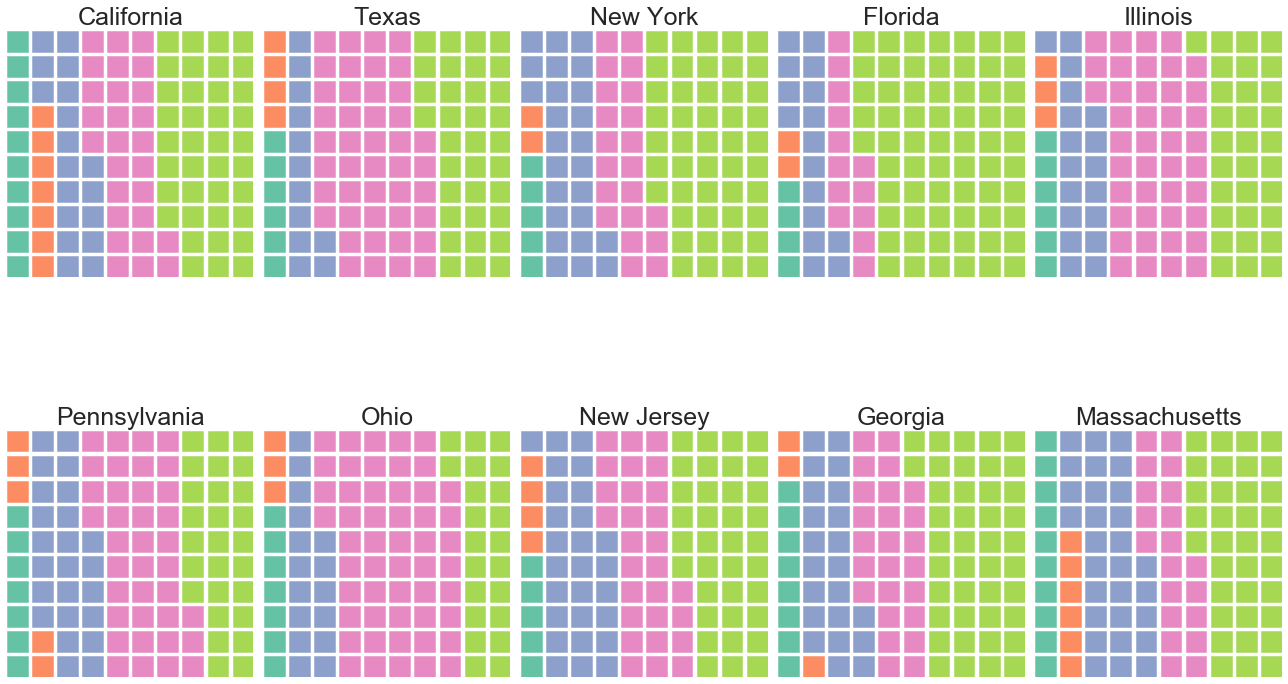

In [102]:
# need to figure out how to reduce the gap between the two rows
import matplotlib.pyplot as plt
from pywaffle import Waffle

fig = plt.figure(
    FigureClass=Waffle,
    plots={
        '251': {
            'values': df_export_2018['California'],
#             'labels': ["{0}".format(n) for n, v in df_export_2018['California'].items()],
#             'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'California', 'loc': 'center', 'size': 25}
        },
        '252': {
            'values': df_export_2018['Texas'],
#             'labels': ["{0} ({1}%) ".format(n, v) for n, v in df_export_2018['Texas'].items()],
#             'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'Texas', 'loc': 'center', 'size': 25}
        },
        '253': {
            'values': df_export_2018['New York'],
#             'labels': ["{0} ({1}%)".format(n, v) for n, v in df_export_2018['New York'].items()],
#             'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'New York', 'loc': 'center', 'size': 25}
        },
         '254': {
            'values': df_export_2018['Florida'],
#             'labels': ["{0} ({1}%)".format(n, v) for n, v in df_export_2018['Florida'].items()],
#             'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'Florida', 'loc': 'center', 'size': 25}
        },
         '255': {
            'values': df_export_2018['Illinois'],
#             'labels': ["{0} ({1}%)".format(n, v) for n, v in df_export_2018['Illinois''].items()],
#             'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'Illinois', 'loc': 'center', 'size': 25}
        },
         '256': {
            'values': df_export_2018['Pennsylvania'],
#             'labels': ["{0} ({1}%)".format(n, v) for n, v in df_export_2018['Pennsylvania'].items()],
#             'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'Pennsylvania', 'loc': 'center', 'size': 25}
        },
         '257': {
            'values': df_export_2018['Ohio'],
#             'labels': ["{0} ({1}%)".format(n, v) for n, v in df_export_2018['Ohio'].items()],
#             'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'Ohio', 'loc': 'center', 'size': 25}
        },
         '258': {
            'values': df_export_2018['New Jersey'],
#             'labels': ["{0} ({1}%)".format(n, v) for n, v in df_export_2018['New Jersey'].items()],
#             'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'New Jersey', 'loc': 'center', 'size': 25}
        },
         '259': {
            'values': df_export_2018['Georgia'],
#             'labels': ["{0} ({1}%)".format(n, v) for n, v in df_export_2018['Georgia'].items()],
#             'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'Georgia', 'loc': 'center', 'size': 25}
        },
         '250': {
            'values': df_export_2018['Massachusetts'],
#             'labels': ["{0} ({1}%)".format(n, v) for n, v in df_export_2018['Massachusetts'].items()],
#             'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'Massachusetts', 'loc': 'center', 'size': 25}
        },        
    },
    rows=10,
    figsize=(18, 18)  # figsize is a parameter of plt.figure
)

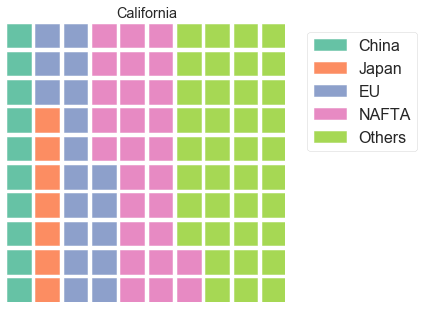

In [103]:
# this is just to get the legend

fig = plt.figure(
    FigureClass=Waffle,
    plots={
        '111': {
            'values': df_export_2018['California'],
            'labels': ["{0}".format(n) for n, v in df_export_2018['California'].items()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize':16},
            'title': {'label': 'California', 'loc': 'center'}
        },
    },
    rows=10,
    figsize=(6, 6)  # figsize is a parameter of plt.figure
)

## Scatter bubble plot of export vs. import for all states

In [ ]:
df_trade_china_2018 = df_trade_china_copy[df_trade_china_copy.Year == 2018]
df_trade_china_2018 = pd.merge(df_trade_china_2018, gdp_2018[['State', 'region', 'gdp']], on='State', how='left')
df_trade_china_2018 = df_trade_china_2018.dropna() # drop first row (US national data)
df_trade_china_2018['gdp'] = (df_trade_china_2018.gdp/1000).astype(int) # convert to billion dollars
df_trade_china_2018.rename(columns={'gdp':'gdp, in billion dollars'}, inplace=True)

df_trade_china_2018.sort_values('gdp, in billion dollars', ascending = False).State.head(10)

2        California
1             Texas
8          New York
19          Florida
9          Illinois
14     Pennsylvania
6              Ohio
22       New Jersey
12          Georgia
13    Massachusetts
Name: State, dtype: object

Text(0, 0.5, 'Export, in Million Dollars')

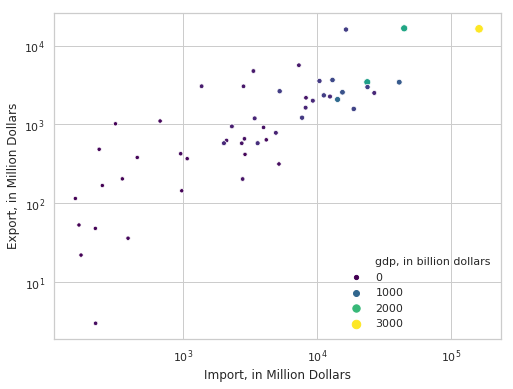

In [ ]:
cmap = plt.get_cmap('viridis')

fig, ax = plt.subplots(figsize=(8, 6))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x="Import", y="Export",
                      hue="gdp, in billion dollars", size="gdp, in billion dollars",
                     data=df_trade_china_2018, ax=ax, palette=cmap)
ax.legend(loc='lower right', frameon=False)
ax.set_xlabel('Import, in Million Dollars')
ax.set_ylabel('Export, in Million Dollars')

# Part II: Visualizations of Manifold-Learning-Based Clustering Analysis

In [56]:
US_export_perc_2018 = df_export_2018.T.reset_index().drop('China', axis = 1)


trade_china_2018 = trade_china.query('Year == 2018') 
trade_world_2018 = trade_world.query('Year == 2018') 
export_percent_2018= (trade_china_2018.set_index(['State', 'Year'])['export_normalized'] \
                  / trade_world_2018.set_index(['State', 'Year'])['export_normalized']).reset_index() 
export_percent_2018.rename(columns = {'export_normalized': 'export_normalized_perc'}, inplace = True)
 


df_ = pd.merge(trade_china_2018, election, how = 'left', on = 'State')
df_ = pd.merge(df_, export_percent_2018, how = 'left', on = 'State')
df_ = pd.merge(df_, gdp_2018, how = 'left', on = 'State')
df_ = df_.drop(['Year_x', 'export', 'import', 'Year_y', ], axis = 1)
df_ = df_[df_.State !='UNITED STATES']


df = pd.merge(df_, US_export_perc_2018, how = 'left', on = 'State')
df.head()

State  export_normalized  import_normalized       Party  \
0           Texas       16586.874848       44494.985568  Republican   
1      California       16345.090150      161186.708150  Democratic   
2      Washington       16001.404764       16358.881032  Democratic   
3  South Carolina        5636.999846        7280.194835  Republican   
4          Oregon        4761.730851        3332.180375  Democratic   

   export_normalized_perc         Q1         Q2         Q3         Q4  \
0                0.052582  1724996.0  1766263.0  1793342.0  1818585.0   
1                0.091618  2899362.0  2967681.0  2987090.0  3018337.0   
2                0.205938   546347.0   560182.0   569449.0   576624.0   
3                0.162745   225947.0   229197.0   231906.0   234367.0   
4                0.213601   233601.0   237318.0   240731.0   243085.0   

      region         gdp  Japan     EU  NAFTA  Others  
0  Southwest  1775796.50   3.76  12.58  43.49   34.91  
1   Far West  2968117.50   7.34  17.85  27.18   38.47  
2   Far West   563150.50   7.84  15.71  14.42   41.44  
3  Southeast   230354.25   4.73  26.07  19.44   33.48  
4   Far West   238683.75   9.80   9.64  16.48   42.72

In [ ]:
df.to_csv('trade_state_2018.csv')


## Manifold learning

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import matplotlib
from sklearn.externals import joblib
plt.style.use('ggplot')
# matplotlib.use('Agg')


from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

        
trade_state_2018 = pd.read_csv('trade_state_2018.csv')
state = trade_state_2018['State']
party = trade_state_2018['Party']
region = trade_state_2018['region']

trade_state_2018.drop('State', axis = 1, inplace = True)

# Identify the categorical features we wish to consider.
cat_attribs = ['Party', 'region']

# Identify the numerical features we wish to consider.
num_attribs = [p for p in trade_state_2018.columns if p not in cat_attribs]        
        
        

        
# pipelines        
num_pipeline = Pipeline([
#     ('Data2matrix', Data2matrix()),
#     ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='mean')), 
    ('std_scalar', StandardScaler()) ])


cat_pipeline = Pipeline([
#         ('selector', DataFrameSelector(cat_attribs)),
        ('imputer', SimpleImputer(strategy='constant')),  # most_frequent
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])


num_cat_pipeline = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_attribs),
    ('cat_pipeline', cat_pipeline, cat_attribs),
], remainder = 'drop' )


data_prep_pipeline = Pipeline([
    ('num_cat_pipe', num_cat_pipeline)        
])    


/Users/dongliang/anaconda3/envs/ai/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [59]:
X = data_prep_pipeline.fit_transform(trade_state_2018)
X.shape

(54, 24)

### t-SNE

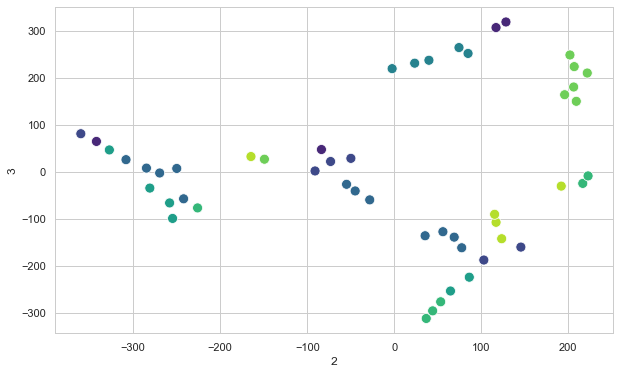

In [61]:
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set_style('whitegrid')

# Implement
def plot_tsne(perplexity, X):
    X_embedded = TSNE(n_components=2, perplexity=perplexity).fit_transform(X)
    data = pd.DataFrame(np.c_[state, region, X_embedded])
    sns.scatterplot(x = 2, y = 3, data = data, hue = 1, s =100, palette = 'viridis',)
    plt.gca().legend().set_visible(False)
#     plt.gcf().set_size_inches(10, 6)

np.random.seed(10)
plot_tsne(perplexity=3, X = X) 
plt.gcf().set_size_inches(10, 6)

### UMAP

In [63]:
import umap
import seaborn as sns
# embedding = umap.UMAP().fit_transform(X)

/Users/dongliang/anaconda3/envs/ai/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../anaconda3/envs/ai/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/dongliang/anaconda3/envs/ai/lib/python3.6/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../anaconda3/envs/ai/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/dongliang/anaconda3/envs/ai/lib/python3.6/site-packages/numba/c

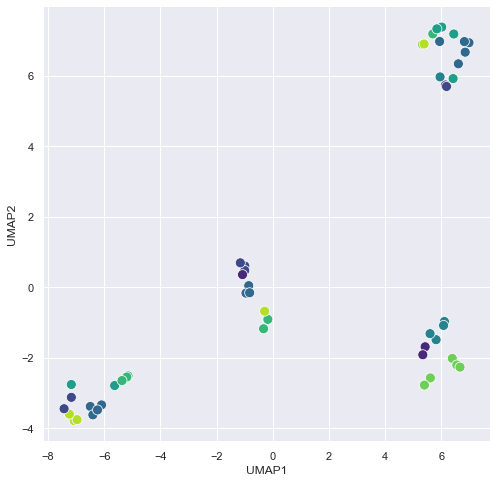

In [64]:
def plot_umap(n_neighbors, X):
    X_umap = umap.UMAP(n_neighbors = n_neighbors, min_dist=0.001).fit_transform(X)
    data = pd.DataFrame(np.c_[state, region, X_umap])
    ax = sns.scatterplot(x = 2, y = 3, data = data, hue = 1, s =100, palette = 'viridis')
#     for i, r in data.iterrows(): 
#         ax.text(data.iloc[:, 2].loc[i], data.iloc[:, 3].loc[i], '%s' % (str(data.iloc[:, 0].loc[i])))
    plt.gca().legend().set_visible(False)
#     plt.gcf().set_size_inches(10, 6)

np.random.seed(10)
sns.set_style("darkgrid")
plot_umap(n_neighbors = 3, X = X) 
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.gcf().set_size_inches(8, 8)

/Users/dongliang/anaconda3/envs/ai/lib/python3.6/site-packages/umap/umap_.py:1385: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "
/Users/dongliang/anaconda3/envs/ai/lib/python3.6/site-packages/umap/umap_.py:1385: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


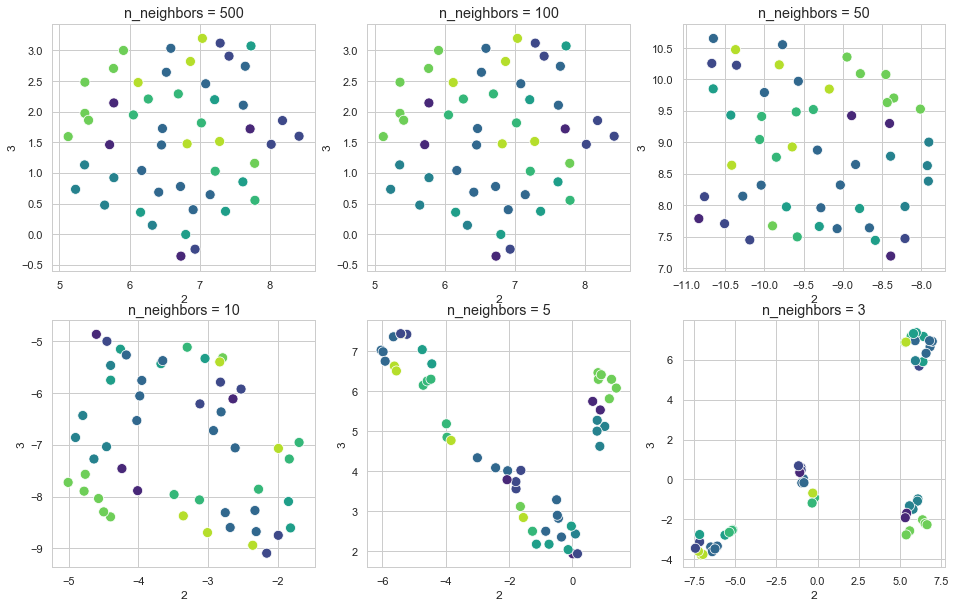

In [65]:
for i, p in enumerate([500, 100, 50,  10, 5, 3 ]):
    np.random.seed(10)
    sns.set_style("whitegrid")
    plt.subplot(2, 3, i + 1)
    plot_umap(p, X = X)
    plt.title(f"n_neighbors = {p}")
    
plt.gcf().set_size_inches(16, 10)   

In [68]:
### K-mean clustering

from sklearn.cluster import KMeans

X_umap = umap.UMAP(n_neighbors = 3, min_dist=0.001).fit_transform(X)

model = KMeans(n_clusters = 4)
model.fit(X_umap)
y_pred = model.predict(X_umap)

state_class = pd.DataFrame(np.c_[state, y_pred], columns = ['State', 'Class']) # .sort_values('Class')
state_class.Class = state_class.Class.replace({0: 'I', 1: 'II', 2: 'III', 3: 'IV'})

In [69]:
state_class.head()

State Class
0           Texas   III
1      California   III
2      Washington    IV
3  South Carolina    IV
4          Oregon    IV

## Choropleth map showing UMAP embeddings of U.S. states

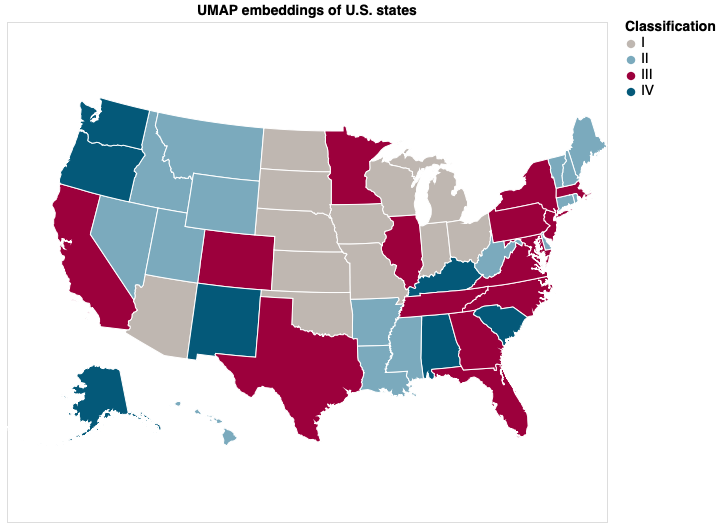

In [75]:
import altair as alt
from vega_datasets import data
import matplotlib.pyplot as plt


import pandas as pd
trade_state_2018 = pd.read_csv('trade_state_2018.csv')
alt.topo_feature(data.us_10m.url, 'states')


keys = pd.read_csv('https://vega.github.io/vega-datasets/data/population_engineers_hurricanes.csv')
keys.set_index('state', inplace = True)

state_class['id'] = keys.loc[state_class['State']]['id'].values.astype(int)
state_class = state_class[state_class.id > 0]




def plot_choropleth(source, color_encoding, title, **kargs): 

  states = alt.topo_feature(data.us_10m.url, 'states')
  variable_list = ['State', 'Class']
  

  plot = alt.Chart(states, title = title).mark_geoshape(stroke= 'white', strokeWidth=1).encode(
      alt.Color(color_encoding, title = 'Classification', 
                scale = alt.Scale(domain=[ 'I', 'II', 'III', 'IV'],
                                  range= [ '#BFB7B1', '#7BAABD',  '#9C003C', '#045979'],
                                  # use the following line to show individual category of US states
#                                   range= ['#BFB7B1', '#7BAABD',  'lightgrey', 'lightgrey'],                                   )
               ), 
      tooltip = ['State:N']
  ).transform_lookup(
      lookup='id',
      from_=alt.LookupData(source, 'id', variable_list )
  ).properties(
      width=600,
      height=500
  ).project(
      type='albersUsa'
  ).resolve_scale(
      color='independent'
  )
    
  return plot
  

    
alt.renderers.enable('default')    
source = state_class
plot_choropleth(source, 'Class:N', 'UMAP embeddings of U.S. states')



## A normalized Bar chart to compare the fractions of the democratic states and republican states based on the classification results

In [222]:
grand = pd.merge(state_class, trade_state_2018, how = 'left', on = 'State')
grand = grand[grand.Party.isin(['Republican', 'Democratic'])]

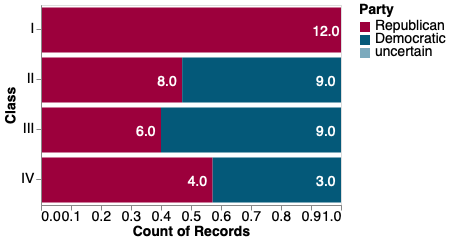

In [83]:
source = grand
bars = alt.Chart(source).mark_bar().encode(
    x=alt.X('count(Party)', stack="normalize"),
    y='Class:N',
    color=alt.Color('Party',
                   scale = alt.Scale(domain=['Republican', 'Democratic',  'uncertain'],
                             range= ['#9C003C', '#045979', '#7BAABD'])
                   )
).properties(
    height = 200, 
    width = 300
)



text = alt.Chart(source).mark_text(dx=-15, dy=3, color='white').encode(
    x=alt.X('count(Party)', stack='normalize'),
    y=alt.Y('Class:N'),
    detail='Party:N',
    text=alt.Text('count(Party)', format='.1f')
)

(bars + text).configure_axis(grid = False)

## A boxplot chart to compare the economic and trade characteristics of different clusters of U.S. states.

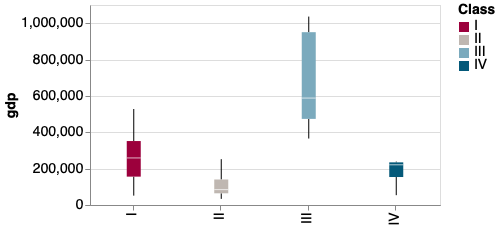

In [109]:
source = grand
def plot_boxplot(y):
    plt = alt.Chart(source).mark_boxplot(outliers = False).encode(
        x=alt.X('Class:N',
                title=None,
                ),
        y=alt.Y(y, 
                stack='center',
#                 axis=alt.Axis(labels=True, values=[0],grid=False, ticks=False)
               ), 
        color=alt.Color('Class', 
                        scale = alt.Scale(domain=[ 'I', 'II', 'III', 'IV'],
                                      range= ['#9C003C', '#BFB7B1', '#7BAABD', '#045979']))
    ).properties(
        width=350,
        height = 200
    )
    return plt
    
# uncomment each of the following line to make boxplot chart    
# plot_boxplot(y = 'import_normalized:Q')    
# plot_boxplot(y = 'export_normalized:Q')     
# plot_boxplot(y = 'export_normalized_perc:Q') 
plot_boxplot(y = 'gdp:Q') 

In [80]:
source

State Class  id  export_normalized  import_normalized       Party  \
0           Texas   III  48       16586.874850       44494.985570  Republican   
1      California   III   6       16345.090150      161186.708200  Democratic   
2      Washington    IV  53       16001.404760       16358.881030  Democratic   
3  South Carolina    IV  45        5636.999846        7280.194835  Republican   
4          Oregon    IV  41        4761.730851        3332.180375  Democratic   

   export_normalized_perc         Q1         Q2         Q3         Q4  \
0                0.052582  1724996.0  1766263.0  1793342.0  1818585.0   
1                0.091618  2899362.0  2967681.0  2987090.0  3018337.0   
2                0.205938   546347.0   560182.0   569449.0   576624.0   
3                0.162745   225947.0   229197.0   231906.0   234367.0   
4                0.213601   233601.0   237318.0   240731.0   243085.0   

      region         gdp  Japan     EU  NAFTA  Others  
0  Southwest  1775796.50   3.76  12.58  43.49   34.91  
1   Far West  2968117.50   7.34  17.85  27.18   38.47  
2   Far West   563150.50   7.84  15.71  14.42   41.44  
3  Southeast   230354.25   4.73  26.07  19.44   33.48  
4   Far West   238683.75   9.80   9.64  16.48   42.72

## A waffle chart to display the export orientation of classified U.S. states

In [98]:
cat1 = ['Washington', 'South Carolina', 'Oregon', 'Alabama', 'Kentucky', 'Puerto Rico', 'New Mexico', 'Alaska', 'Connecticut', 'Utah', 'New Hampshire']
cat2 = ['Texas', 'California', 'New York', 'Illinois', 'Georgia', 'Massachusetts', 'Pennsylvania', 'Tennessee', 'North Carolina', 'Minnesota', 'Florida', 'New Jersey', 'Virginia', 'Maryland', 'Colorado']
cat3 = ['Louisiana', 'Nevada', 'Mississippi', 'West Virginia', 'Idaho', 'Delaware', 'Arkansas', 'Maine', 'Vermont', 'Rhode Island', 'Montana', 'Wyoming', 'Hawaii', 'District of Columbia']
cat4 = ['Ohio', 'Michigan', 'Indiana', 'Wisconsin', 'Arizona', 'Missouri', 'Kansas', 'Iowa', 'Nebraska', 'Oklahoma', 'South Dakota', 'North Dakota']

In [99]:
df_export_2018_copy.head()

State       China_       Japan_          EU_       NAFTA_  \
0     Alabama   3045648637    821180018   5146457664   6641461199   
1      Alaska   1019182118    792384838   1001917540    679975655   
2     Arizona   1193594160    753250696   3949840826   9797826861   
3    Arkansas    314610271    167547100   1198426018   2076745617   
4  California  16345090150  13099540659  31841122069  48488959762   

         World_  
0   21349242744  
1    4773109763  
2   22388342080  
3    6466443255  
4  178404767473

In [104]:
# some data wrangling to make it compatible for waffle chart

ml_result = []


for cat in [cat1, cat2, cat3, cat4]:
  ml_result.append(df_export_2018_copy[df_export_2018_copy.State.isin(cat)].sum())
  
df_ml = pd.concat(ml_result, axis=1)

df_ml.columns = ['I', 'II', 'III', 'IV']

df_ml = df_ml.iloc[1:, :]

df_ml.index = ['China', 'Japan', 'EU', 'NAFTA', 'Others']

df_ml.iloc[:-1, :] = (df_ml.iloc[:-1, :]/df_ml.iloc[-1, :])*100

df_ml.iloc[-1, :] = 100 - df_ml.iloc[:-1, :].sum()



Waffle chart for manifold learning result

In [105]:
df_ml

I       II      III       IV
China   14.6358  6.30619  5.45549  5.71387
Japan   6.27466  4.49296  3.50639  4.00891
EU      27.6478  18.3911  16.8876  16.4181
NAFTA   19.2351  32.7923  21.8435  51.9255
Others  32.2066  38.0174   52.307  21.9336

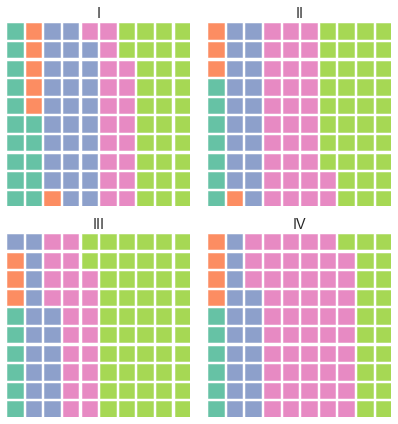

In [106]:
# waffle chart for the 4 categories

fig = plt.figure(
    FigureClass=Waffle,
    plots={
        '221': {
            'values': df_ml['I'],
#             'labels': ["{0}".format(n) for n, v in df_ml['I'].items()],
#             'legend': {'loc': 'center left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'I', 'loc': 'center'}
        },
        '222': {
            'values': df_ml['II'],
#             'labels': ["{0} ({1}%) ".format(n, v) for n, v in df_export_2018['Texas'].items()],
#             'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'II', 'loc': 'center'}
        },
        '223': {
            'values': df_ml['III'],
#             'labels': ["{0} ({1}%)".format(n, v) for n, v in df_export_2018['New York'].items()],
#             'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'III', 'loc': 'center'}
        },
         '224': {
            'values': df_ml['IV'],
#             'labels': ["{0} ({1}%)".format(n, v) for n, v in df_export_2018['Florida'].items()],
#             'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'IV', 'loc': 'center'}
        },       
    },
    rows=10,
    figsize=(6,6)  # figsize is a parameter of plt.figure
)